In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, Video

## Libs

- numpy
- matplotlib
- gymnasium (openai gym)
- moviepy (for recording video of agent playing)
- tensorflow / tensorflow[and-cuda]

## Documentations / References.

Documentation on gym / gymnasium can be found here: [https://gymnasium.farama.org/api/env/], it has good documentation on all the functions. - Do not use the one "showed" in exam paper: [https://www.gymlibrary.dev/index.html], since it has pretty bad documentation.

# [TASK-1] Overview of the Environment.

## Grid

The taxi can move on all nodes except $X$.

For each step it takes, it will be given $-1$ rewards, if successfully deliver passenger $+20$ reward points is granted. On failure on pickup and dropoff $-10$ reward points are granted.

$$
\begin{bmatrix}
\text{RED}_{11} & x_{12} & \text{X} & x_{14} & \text{GREEN}_{15} \\
x_{21} & x_{22} & \text{X} & x_{24} & x_{25} \\
x_{31} & x_{32} & x_{33} & x_{34} & x_{35} \\
x_{41} & \text{X} & x_{43} & x_{44} & x_{45} \\
\text{YELLOW}_{51} & \text{X} & x_53 & \text{BLUE}_{54} & x_{55}
\end{bmatrix}
$$

## Actions
0: move south

1: move north

2: move east

3: move west

4: pickup passenger

5: drop off passenger

## Observation space.

The taxi can dropoff passanger on (0)$\text{RED}_{11}$, (1)$\text{GREEN}_{15}$, (2)$\text{YELLOW}_{51}$, (3)$\text{BLUE}_{54}$.
That means that the passanger can be on all these stats, and additionally (4)$\text{in taxi}$.

The grid is **5x5** resulting in **25** different locations for the taxi.

$4_{destinations} * 5_{passanger_locations} * 25_{nodes} = 500_{states}$

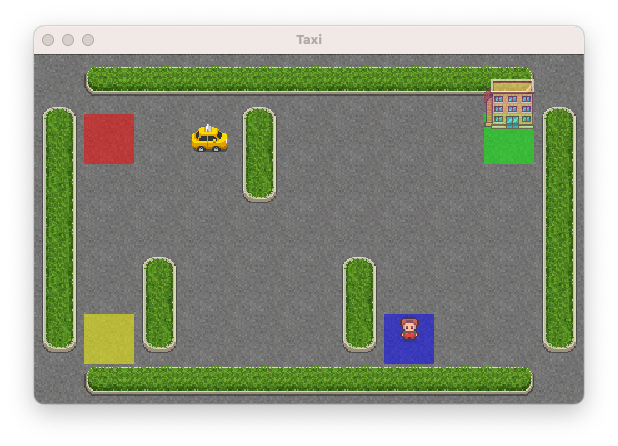

In [5]:
Image(filename='./static/Environment.png')

# Q-Learning Agent

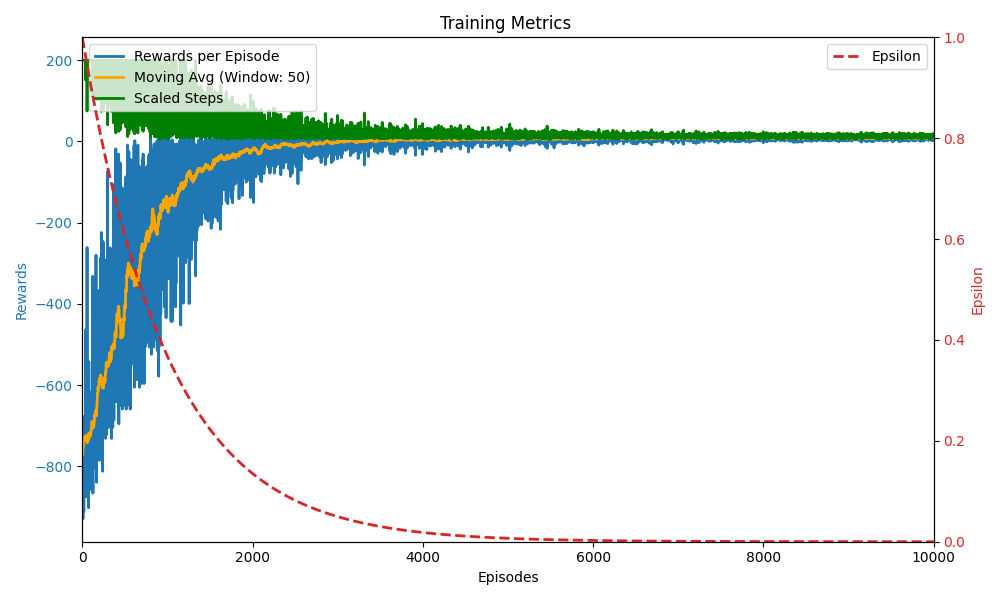

In [6]:
Image(filename='./static/metrics/basic.png')

In [7]:
Video('./static/movies/basic/rl-video-episode-0.mp4')

# Sarsa Agent

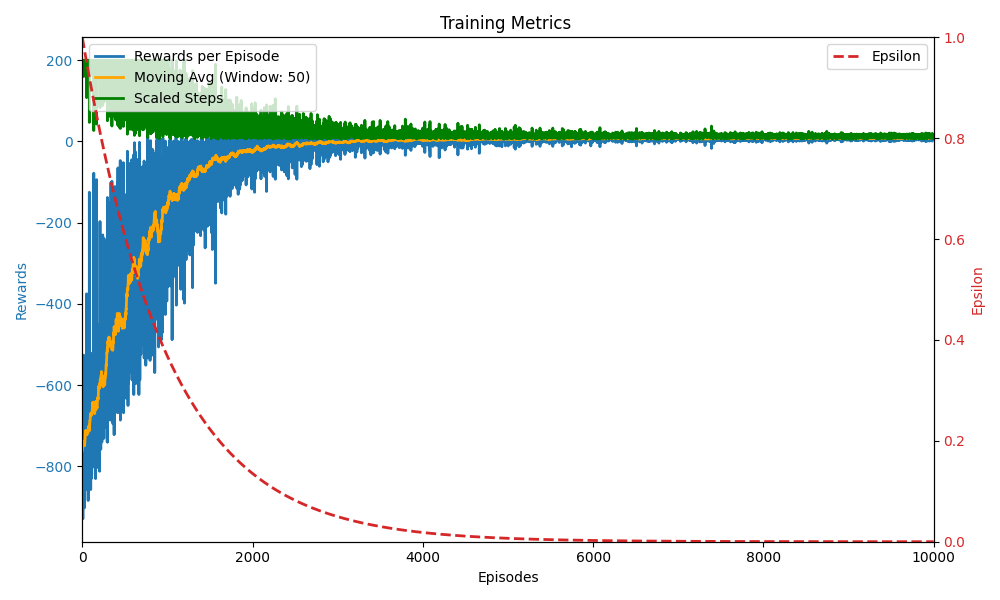

In [8]:
Image(filename='./static/metrics/sarsa.png')

In [9]:
Video('./static/movies/sarsa/rl-video-episode-0.mp4')

# Deep Q Agent

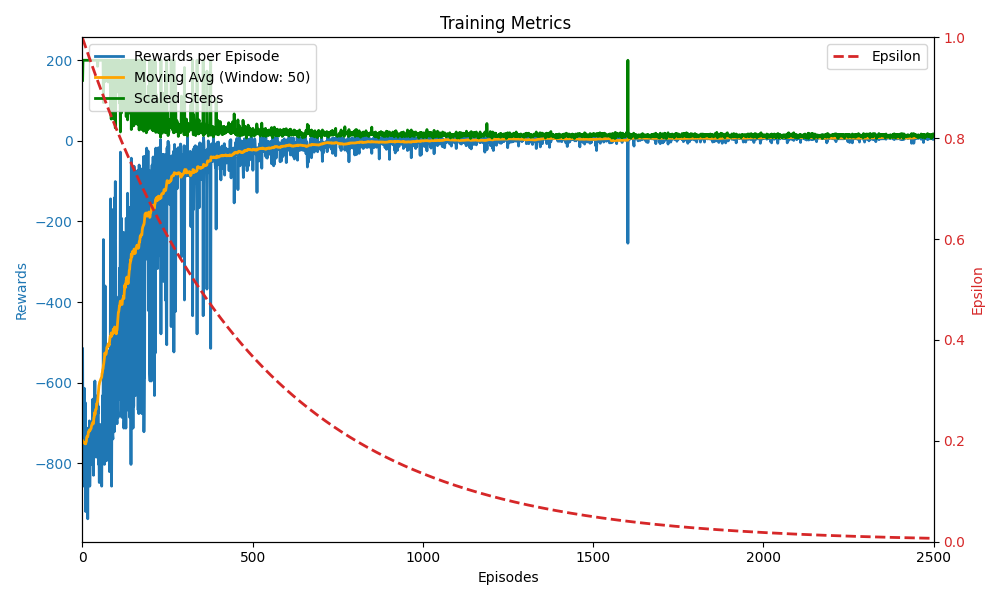

In [10]:
Image(filename='./static/metrics/dql.png')

In [11]:
Video('./static/movies/dql/rl-video-episode-0.mp4')

In [13]:
random_df = pd.read_csv('./static/metrics/random.csv')
heuristic_df = pd.read_csv('./static/metrics/heuristic.csv')
basic_q_df = pd.read_csv('./static/metrics/basic.csv')
sarsa_df = pd.read_csv('./static/metrics/sarsa.csv')
dql_df = pd.read_csv('./static/metrics/dql.csv')

# Analysis of results
- [ ] Analyse the metrics
- [ ] Clean the metrics: calculate the elapsed time from episode 1 to the next.
- [ ] Plot all average moving rewards on one chart.

In [ ]:
random_df.describe()

,rewards,steps,epsilon
count,10001.000000,10001.000000,10001.0
mean,-771.877612,196.797620,1.0
std,98.945500,17.763734,0.0
min,-1019.000000,27.000000,1.0
25%,-830.000000,200.000000,1.0
50%,-785.000000,200.000000,1.0
75%,-740.000000,200.000000,1.0
max,-46.000000,200.000000,1.0
